# Two fires, varying wind

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import multivariate_normal
from scipy.integrate import solve_bvp
import matplotlib.image as mpimg
from scipy import ndimage
from PIL import Image

In [3]:
w1_init = 1.0
w2_init = -0.5

alpha, beta = 0.5, 1.3
gamma, lam = 0.3, 1.5

def get_wind(t):
    w1 = w1_init + alpha * np.sin(beta * t)
    w2 = w2_init + gamma * np.cos(lam * t)
    mag = np.hypot(w1, w2)
    w1 = np.where(mag < 0.1, w1 / mag, w1)
    w2 = np.where(mag < 0.1, w2 / mag, w2)
    return w1, w2

In [4]:
fire_cost = 50_000 # Cost of fire

def fire(t, x, y, x0, y0, sigma2_0, k, c):
    """
    Fire dynamics model.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    float: Fire intensity at time t
    """
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)

    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements for each t
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute determinant and inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")

    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    # Compute exponent
    exponent = -0.5 * (inv_11 * dx**2 + 2 * inv_12 * dx * dy + inv_22 * dy**2)
    normalization = 1.0 / (2 * np.pi * np.sqrt(det))
    return fire_cost * normalization * np.exp(exponent)


def grad_fire(t, x, y, x0, y0, sigma2_0, k, c):
    """
    Gradient of fire intensity.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    np.ndarray: Gradient of fire intensity
    """
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)
    
    f = fire(t, x, y, x0, y0, sigma2_0, k, c)
    
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")
    
    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    grad_x = -f * (inv_11 * dx + inv_12 * dy)
    grad_y = -f * (inv_12 * dx + inv_22 * dy)
    
    return grad_x, grad_y

In [5]:
target = np.array([30, 0])  # Target (x, y) coordinates

# Fire and wind parameters
x0, y0 = 0, 0
sigma_0 = 1
k, c = 3, 1
w1_init, w2_init = 1.0, -0.5

fire1_init = np.array([6.25, -0.5])  # Initial fire position
fire2_init = np.array([18., 5.0])  # Initial fire position

In [6]:
# Parameters
target = np.array([30., 0.])
sigma_0 = 0.1
k = 2.0
c = 1
control_penalty = 0.9
time_penalty = 100
fire_cost = 50_000

s0 = np.array([0, 0, 0, 0])

def fire_ode(t, z, p):
    x, y, vx, vy, p1, p2, p3, p4 = z
    tf = np.clip(p[0], 0, None)
    f1_x, f1_y = grad_fire(tf * t, x, y, fire1_init[0], fire1_init[1], sigma_0, k, c)
    f2_x, f2_y = grad_fire(tf * t, x, y, fire2_init[0], fire2_init[1], sigma_0, k, c)
    return tf * np.array([
        vx,
        vy,
        0.5 * p3 / control_penalty,
        0.5 * p4 / control_penalty,
        f1_x + f2_x,
        f1_y + f2_y,
        -p1,
        -p2
    ])

def bc(ya, yb, p):
    x, y, vx, vy, p1, p2, p3, p4 = yb
    u1, u2 = 0.5 * p3 / control_penalty, 0.5 * p4 / control_penalty
    tf = np.clip(p[0], 0, None)
    fire1 = fire(tf, x, y, fire1_init[0], fire1_init[1], sigma_0, k, c)
    fire2 = fire(tf, x, y, fire2_init[0], fire2_init[1], sigma_0, k, c)
    H = p1*vx + p2*vy + p3*u1 + p4*u2 - (time_penalty + fire1 + fire2 + control_penalty * (u1**2 + u2**2))
    return np.array([
        ya[0] - s0[0],
        ya[1] - s0[1],
        ya[2] - s0[2],
        ya[3] - s0[3],
        yb[0] - target[0],
        yb[1] - target[1],
        yb[2],
        yb[3],
        H
    ]) 

# Initial mesh and guess
t_steps = 500
t = np.linspace(0, 1, t_steps)
z0 = np.zeros((8, t_steps))
z0[0, :] = np.linspace(s0[0], target[0], t_steps)
z0[1, :] = np.linspace(s0[1], target[1], t_steps)
p0 = np.array([1.0])
v_guess = (target - s0[:2]) / p0[0]
z0[2, :] = v_guess[0]
z0[3, :] = v_guess[1]

# Solve BVP
sol = solve_bvp(fire_ode, bc, t, z0, p0, tol=1e-2, max_nodes=1_000_00)

if not sol.success:
    print("BVP solver failed:", sol.message)

Text(0.5, 1.0, 'Final time: 4.57')

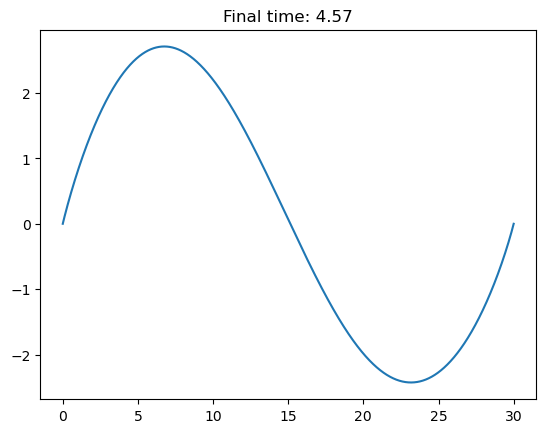

In [7]:
plt.plot(sol.y[0], sol.y[1], label='Trajectory')
plt.title(f"Final time: {sol.p[0]:.2f}")

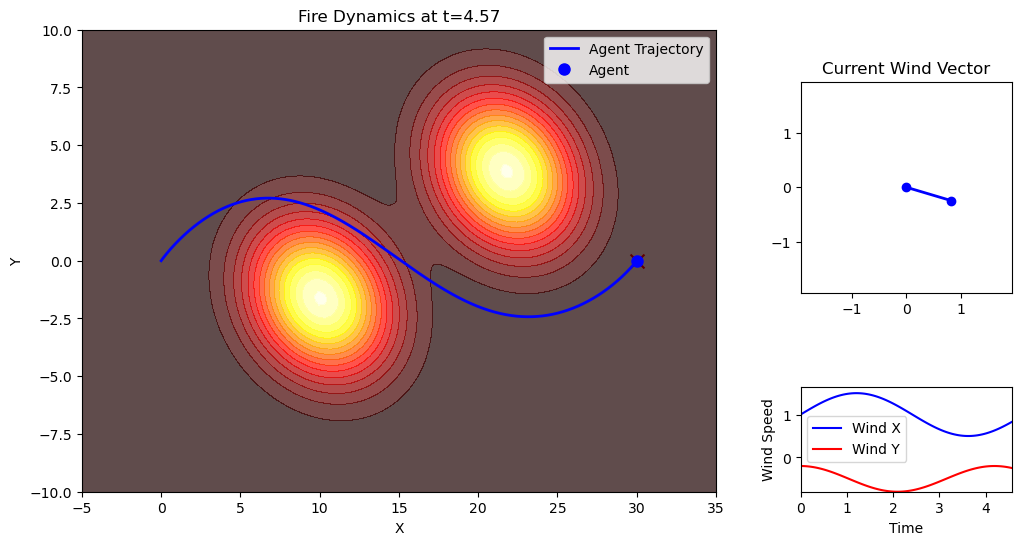

In [8]:
np.seterr(invalid='ignore')

def get_wind(t):
    w1 = w1_init + alpha * np.sin(beta * t)
    w2 = w2_init + gamma * np.cos(lam * t)
    mag = np.hypot(w1, w2)
    w1 = np.where(mag < 0.1, w1 / mag, w1)
    w2 = np.where(mag < 0.1, w2 / mag, w2)
    return w1, w2

# Extract agent trajectory and timing from your solution
tf = sol.p[0]
t_eval = np.linspace(0, tf, len(sol.y[0]))
x_traj = sol.y[0]
y_traj = sol.y[1]

t_values = np.linspace(0, tf, 100)

w1_list, w2_list = zip(*[get_wind(t) for t in t_values])

# Mesh for fire density
x, y = np.linspace(-5, 35, 100), np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Set up figure and layout
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])

# Main fire + trajectory plot
main_ax = fig.add_subplot(gs[:, 0])
main_ax.set_xlim(-5, 35)
main_ax.set_ylim(-10, 10)
main_ax.set_xlabel('X')
main_ax.set_ylabel('Y')
main_ax.set_title(f'Final Time: {tf:.2f}', fontsize=20)

# Wind vector subplot
vector_ax = fig.add_subplot(gs[0, 1])
max_wind = max(np.hypot(w1, w2) for w1, w2 in zip(w1_list, w2_list)) * 1.2
vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
              aspect='equal', title='Current Wind Vector')

# Wind evolution subplot
wind_ax = fig.add_subplot(gs[1, 1])
wind_ax.set(xlim=(0, tf), 
            ylim=(min(min(w1_list), min(w2_list)), max(max(w1_list), max(w2_list)) * 1.1),
            xlabel='Time', ylabel='Wind Speed')
wind_line1, = wind_ax.plot([], [], 'b-', label='Wind X')
wind_line2, = wind_ax.plot([], [], 'r-', label='Wind Y')
wind_ax.legend()

# Initialize dynamic elements
contour = None
traj_line, = main_ax.plot([], [], 'b-', lw=2, label='Agent Trajectory')
current_pos, = main_ax.plot([], [], 'bo', markersize=8, label='Agent')
main_ax.legend()

# Static target
main_ax.scatter(target[0], target[1], marker='x', color='red', s=100, label='Target')

def update(i):
    t = t_values[i]
    global contour
    if contour is not None:
        for coll in contour.collections:
            coll.remove()
    
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)
    
    mean1 = [fire1_init[0] + w1 * t, fire1_init[1] + w2 * t]
    mean2 = [fire2_init[0] + w1 * t, fire2_init[1] + w2 * t]
    sigma_parallel = sigma_0 + k * t
    sigma_perp = sigma_0 + c * t

    Sigma = np.array([
        [u_x**2 * sigma_parallel + u_y**2 * sigma_perp, 
         u_x * u_y * (sigma_parallel - sigma_perp)],
        [u_x * u_y * (sigma_parallel - sigma_perp), 
         u_y**2 * sigma_parallel + u_x**2 * sigma_perp]
    ])

    Z1 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean1, cov=Sigma)
    Z2 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean2, cov=Sigma)

    Z = Z1 + Z2

    contour = main_ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.7)
    main_ax.set_title(f'Fire Dynamics at t={t:.2f}')

    # Wind vector arrow (line from origin)
    vector_ax.clear()
    vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
                  aspect='equal', title='Current Wind Vector')
    color = 'blue' if w1 >= 0 else 'red'
    vector_ax.plot([0, w1], [0, w2], color=color, linewidth=2, marker='o')

    # Update wind over time plot
    wind_line1.set_data(t_values[:i+1], w1_list[:i+1])
    wind_line2.set_data(t_values[:i+1], w2_list[:i+1])

    # Update trajectory and current position
    mask = t_eval <= t
    traj_line.set_data(x_traj[mask], y_traj[mask])
    if mask.any():
        current_pos.set_data([x_traj[mask][-1]], [y_traj[mask][-1]])

    return [*contour.collections, traj_line, current_pos, wind_line1, wind_line2]

# Animate
ani = animation.FuncAnimation(
    fig, update, frames=len(t_values),
    interval=50, blit=False, repeat=True
)

ani.save('animations/fire2_varyw.mp4', writer='ffmpeg', fps=20)
plt.show()

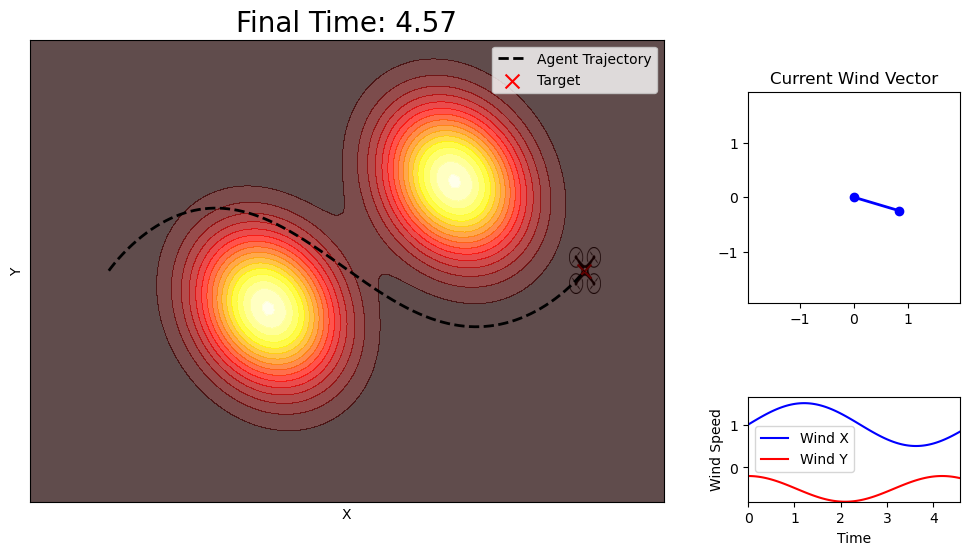

In [12]:
np.seterr(invalid='ignore')

def get_wind(t):
    w1 = w1_init + alpha * np.sin(beta * t)
    w2 = w2_init + gamma * np.cos(lam * t)
    mag = np.hypot(w1, w2)
    w1 = np.where(mag < 0.1, w1 / mag, w1)
    w2 = np.where(mag < 0.1, w2 / mag, w2)
    return w1, w2

# Extract agent trajectory and timing from your solution
tf = sol.p[0]
t_eval = np.linspace(0, tf, len(sol.y[0]))
x_traj = sol.y[0]
y_traj = sol.y[1]

t_values = np.linspace(0, tf, 100)

w1_list, w2_list = zip(*[get_wind(t) for t in t_values])

# Mesh for fire density
x, y = np.linspace(-5, 35, 100), np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Set up figure and layout
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])

# Main fire + trajectory plot
main_ax = fig.add_subplot(gs[:, 0])
main_ax.set_facecolor('white')  # Set light background color

main_ax.set_xlim(-5, 35)
main_ax.set_ylim(-10, 10)
main_ax.set_xlabel('X')
main_ax.set_ylabel('Y')
main_ax.set_title(f'Final Time: {tf:.2f}', fontsize=20)


# Wind vector subplot
vector_ax = fig.add_subplot(gs[0, 1])
max_wind = max(np.hypot(w1, w2) for w1, w2 in zip(w1_list, w2_list)) * 1.2
vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
              aspect='equal', title='Current Wind Vector')

# Wind evolution subplot
wind_ax = fig.add_subplot(gs[1, 1])
wind_ax.set(xlim=(0, tf), 
            ylim=(min(min(w1_list), min(w2_list)), max(max(w1_list), max(w2_list)) * 1.1),
            xlabel='Time', ylabel='Wind Speed')
wind_line1, = wind_ax.plot([], [], 'b-', label='Wind X')
wind_line2, = wind_ax.plot([], [], 'r-', label='Wind Y')
wind_ax.legend()

# Initialize dynamic elements
contour = None
traj_line, = main_ax.plot([], [], 'k--', lw=2, label='Agent Trajectory')
main_ax.legend()

drone_img = mpimg.imread('drone2.png')
drone_size = 1.0
drone = main_ax.imshow(drone_img, aspect='auto', extent=[-100, -99, -100, -99])

# Static target
main_ax.scatter(target[0], target[1], marker='x', color='red', s=100, label='Target')
main_ax.legend()

main_ax.set_title(f'Final Time: {tf:.2f}', fontsize=20)
main_ax.set_xticks([])
main_ax.set_yticks([])

def update(i):
    t = t_values[i]
    global contour
    if contour is not None:
        for coll in contour.collections:
            coll.remove()
    
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)
    
    mean1 = [fire1_init[0] + w1 * t, fire1_init[1] + w2 * t]
    mean2 = [fire2_init[0] + w1 * t, fire2_init[1] + w2 * t]
    sigma_parallel = sigma_0 + k * t
    sigma_perp = sigma_0 + c * t

    Sigma = np.array([
        [u_x**2 * sigma_parallel + u_y**2 * sigma_perp, 
         u_x * u_y * (sigma_parallel - sigma_perp)],
        [u_x * u_y * (sigma_parallel - sigma_perp), 
         u_y**2 * sigma_parallel + u_x**2 * sigma_perp]
    ])

    Z1 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean1, cov=Sigma)
    Z2 = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean2, cov=Sigma)

    Z = Z1 + Z2

    contour = main_ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.7)

    # Wind vector arrow (line from origin)
    vector_ax.clear()
    vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
                  aspect='equal', title='Current Wind Vector')
    color = 'blue' if w1 >= 0 else 'red'
    vector_ax.plot([0, w1], [0, w2], color=color, linewidth=2, marker='o')

    # Update wind over time plot
    wind_line1.set_data(t_values[:i+1], w1_list[:i+1])
    wind_line2.set_data(t_values[:i+1], w2_list[:i+1])

    # Update trajectory and current position
    mask = t_eval <= t
    traj_line.set_data(x_traj[mask], y_traj[mask])
    if mask.any():
        x_curr, y_curr = x_traj[mask][-1], y_traj[mask][-1]
        done_extent = [
            x_curr - drone_size, x_curr + drone_size,
            y_curr - drone_size, y_curr + drone_size
        ]
        drone.set_extent(done_extent)

    return [*contour.collections, traj_line, wind_line1, wind_line2]

# Animate
ani = animation.FuncAnimation(
    fig, update, frames=len(t_values),
    interval=50, blit=False, repeat=True
)

ani.save('animations/fire2_drone_varyw.mp4', writer='ffmpeg', fps=20)
plt.show()

In [10]:
frame_indices = [30, 70, 99]
output_filenames = ['fire2_drone_varyw_early.png', 'fire2_drone_varyw_mid.png', 'fire2_drone_varyw_end.png']

for idx, frame in zip(frame_indices, output_filenames):
    update(idx)
    fig.savefig(frame, bbox_inches='tight', dpi=800)